In [1]:
from typing import Annotated
import os

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

import config

os.environ["TAVILY_API_KEY"] = config.TAVILY_API_KEY
tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

In [4]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal["researcher", "coder", "FINISH"]


llm = ChatAnthropic(model="claude-3-5-sonnet-latest", api_key=config.ANTHROPIC_API_KEY)


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal["researcher", "coder", "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [5]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm, tools=[tavily_tool], prompt="You are a researcher. DO NOT do any math."
)


def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: State) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()

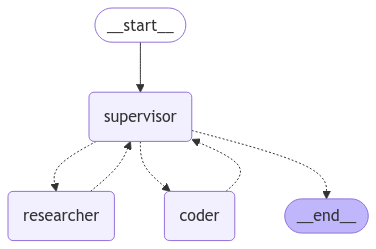

In [6]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'coder'}})
----


Python REPL can execute arbitrary code. Use with caution.


(('coder:d9b16901-63dd-a5dd-9f28-ddc67215f734',), {'agent': {'messages': [AIMessage(content=[{'text': "I'll help you calculate the square root of 42 using Python.", 'type': 'text'}, {'id': 'toolu_01PfxZfydT7soFzFYo76WCSe', 'input': {'code': 'import math\nprint(math.sqrt(42))'}, 'name': 'python_repl_tool', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01FG8rXf7yj1tXpBhaXYKKRR', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 435, 'output_tokens': 82}}, id='run-80673edd-da67-47d5-87e3-7b72886f473a-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'import math\nprint(math.sqrt(42))'}, 'id': 'toolu_01PfxZfydT7soFzFYo76WCSe', 'type': 'tool_call'}], usage_metadata={'input_tokens': 435, 'output_tokens': 82, 'total_tokens': 517, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}})]}})
----
(('coder:d9b16901-63dd-a5

In [8]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the latest GDP of New York and California, then calculate the average",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:e384ab83-f3b0-b3c7-c9d0-9726196cd189',), {'agent': {'messages': [AIMessage(content=[{'text': "I'll help you search for the latest GDP figures for New York and California. Since I need to look up current economic data, I'll use the search function. I'll search for each state separately to ensure accuracy.", 'type': 'text'}, {'id': 'toolu_01PToD3un53DnWec1ua4ev56', 'input': {'query': 'New York state GDP latest figures 2023'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01Jw8d5t3L8GXMGB3xEpWVyZ', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 442, 'output_tokens': 111}}, id='run-8e35bbfa-428b-4ad7-9148-3b3f6d9ffe73-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'New York state GDP latest figures 2023'}, 